In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gcs 
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import coordinates as coord

In [2]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [3]:
refframe={
    "vLSR": [0, 240, 0],
    "vSun": [11.1, 12.24, 7.25],
    "galcen_distance": 8340,
    "z_sun": 27,
    "unit":{
        "vLSR": u.km/u.s,
        "vSun": u.km/u.s,
        "galcen_distance": u.pc,
        "z_sun": u.pc
    }
}

vSun = refframe['vSun']*u.Unit(refframe['unit']["vSun"])
vLSR = refframe['vLSR']*u.Unit(refframe['unit']["vLSR"])
galcen_distance=refframe['galcen_distance']*u.Unit(refframe['unit']['galcen_distance'])
z_sun=refframe['z_sun']*u.Unit(refframe['unit']['z_sun'])   
refferenceframe=coord.Galactocentric(galcen_distance = galcen_distance,galcen_v_sun=vLSR+vSun,z_sun=z_sun)

In [4]:
## Set the global variables
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"
MWpotential="pouliasis2017pii-GCNBody"
MWpot_vanil="pouliasis2017pii"

outname = "stream_on_sky_{:s}_{:s}_{:s}_{:s}.png".format(GCname,montecarlokey,MWpotential,MWpot_vanil)

In [5]:
# load the position of the globular cluster on the sky
pathInitialConditions=gcs.path_handler.MonteCarloObservables(GCname)
Mass,Size,RA,DEC,Rsun,RV,mu_delta,mualpha=gcs.extractors.MonteCarloObservables.extract_GC_observables(pathInitialConditions,montecarlokey)
my_sky=SkyCoord(ra=RA, dec=DEC, distance=Rsun, pm_ra_cosdec=mualpha, pm_dec=mu_delta, radial_velocity=RV).transform_to("galactic")
my_sky.l.wrap_angle=180*u.deg

In [6]:
# load the stream
streampath=gcs.path_handler.old_streams(MWpotential=MWpotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP,)
_,xp,yp,zp,vxp,vyp,vzp=gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP,)

In [7]:
# load the full stream
streampathVanilla=gcs.path_handler.old_streams(MWpotential=MWpot_vanil, GCname=GCname,montecarlokey=montecarlokey,NP=NP,)
# load the vanilla stream
_,xpV,ypV,zpV,vxpV,vypV,vzpV=gcs.extractors.Stream.extract_old_streams(streampathVanilla,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP,)

In [8]:
# put the stream on the sky 
mySkyCoords = SkyCoord(
    x=xp*u.kpc, y=yp*u.kpc, z=zp*u.kpc, 
    v_x=vxp*u.km/u.s, v_y=vyp*u.km/u.s, v_z=vzp*u.km/u.s, 
    frame=refferenceframe, representation_type='cartesian')
# same for vanilla
mySkyCoordsV = SkyCoord(
    x=xpV*u.kpc, y=ypV*u.kpc, z=zpV*u.kpc, 
    v_x=vxpV*u.km/u.s, v_y=vypV*u.km/u.s, v_z=vzpV*u.km/u.s, 
    frame=refferenceframe, representation_type='cartesian')
galacticCoords=mySkyCoords.transform_to("galactic")
galacticCoordsV=mySkyCoordsV.transform_to("galactic")

In [9]:
# filter the stream to only get a region we want
myL=galacticCoords.l.wrap_at(180*u.deg).degree - my_sky.l.value
myB=galacticCoords.b.degree-my_sky.b.value
myLV=galacticCoordsV.l.wrap_at(180*u.deg).degree - my_sky.l.value
myBV=galacticCoordsV.b.degree-my_sky.b.value

bottomFilter = myB > -50
topFilter = myB < 10

leftFilter = myL > -50
rightFilter = myL < 35

streamFilter = bottomFilter & topFilter & leftFilter & rightFilter

myL=myL[streamFilter]
myB=myB[streamFilter]
myLV=myLV[streamFilter]
myBV=myBV[streamFilter]

In [10]:
nBins=int(np.ceil(np.sqrt(myL.shape[0])))
counts,edges = np.histogram(myL, bins=nBins)
countsV,_ = np.histogram(myLV, bins=edges)
normalized_counts = counts / NP
normalized_countsV = countsV / NP
centers = (edges[:-1] + edges[1:]) / 2

# Prepare data for step plot
x = np.repeat(edges, 2)[1:-1]
y = np.repeat(normalized_counts, 2)
yV= np.repeat(normalized_countsV, 2)


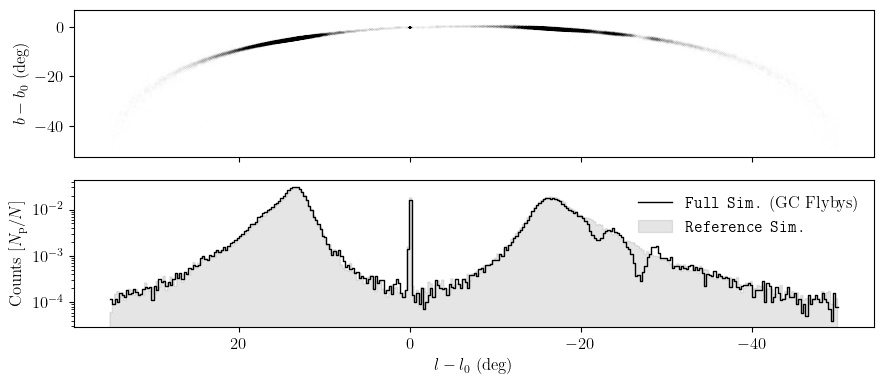

In [11]:
fig, axis = plt.subplots(2, 1, figsize=(9, 4),sharex=True)
axis[0].scatter(myL, myB, s=0.01, c="k", alpha=0.05)
axis[1].plot(x, y, color='k',linewidth=1,label=r"\texttt{Full Sim.} (GC Flybys)")  # Plot the outline of the histogram
axis[1].fill_between(x, yV, color='gray', alpha=0.2, label=r'\texttt{Reference Sim.}')
axis[1].set_yscale('log')
axis[1].set_xlabel(r'$l-l_0$ (deg)')
axis[0].set_ylabel(r'$b-b_0$ (deg)')
axis[1].set_ylabel('Counts [$N_{\mathrm{p}}/N$]')
# axis[0].text(-40,-25,r"($l_0,b_0$)=(%.2f$^{\circ}$,%.2f$^{\circ}$)"%(my_sky.l.to(u.deg).wrap_at(180*u.deg).degree,my_sky.b.to(u.deg).degree),fontsize=12)
axis[1].invert_xaxis()
axis[1].legend(frameon=False)
fig.tight_layout()
fig.savefig("../paper/"+outname, dpi=300, bbox_inches='tight')

writing equations with markdown is so convienent! 


$$ \ddot{\vec{g}}_i = -\nabla \Phi + \left.\sum_{j\neq i} \frac{Gm_j}{\left(|\vec{r_j} - \vec{r_i}|^2 + b_j^2\right)^{3/2}}\right. \left(\vec{r}_j - \vec{r}_i\right)
$$

$$ \ddot{\vec{r}}_p = -\nabla \Phi(R_p,z_p) + \left.\sum_{j} \frac{Gm_j}{\left(|\vec{r_j}(t) - \vec{r_p}|^2 + b_j^2\right)^{3/2}}\right. \left(\vec{r}_j(t)- \vec{r}_p\right)
$$

## Compare with Banik and Bovy 2017

In Bovy 2017 he said the power spectrum is very important since we are looking at statistics... let us see

"We compute the power spectrum of the density fluctuations for a single simulation by taking the perturbed density and dividing it by the density of the unperturbed stream (e.g. Fig. 10) and computing the one-dimensional power spectrum using a Hann window (e.g. Press et al. 2007). In practice, we use the csd routine in SCIPY (Jones et al. 2001) and do not divide by the sampling frequency. In all of the figures, we plot the square root of the power spectrum versus the inverse of the frequency, such that the y- and x-axes represent the typical value of fluctuations at a given spatial scale"

In [12]:
from scipy import signal
# apply a box car filter to the data
smoothed_normalized_counts = signal.convolve(normalized_counts, np.ones(10)/10, mode='same')
smoothed_normalized_countsV = signal.convolve(normalized_countsV, np.ones(10)/10, mode='same')

density_fluctuations = smoothed_normalized_counts/smoothed_normalized_countsV
# Apply a Hann window
window = signal.windows.hann(len(density_fluctuations))
windowed_fluctuations = density_fluctuations * window
# Compute the power spectrum using the csd routine

frequencies, power_spectrum = signal.csd(windowed_fluctuations, windowed_fluctuations, window=window, nperseg=len(windowed_fluctuations))
# convert frequencies to the units of the input data
frequencies = frequencies * (edges[-1] - edges[0])
# get the power spectrum of each stream
frequenciesV, power_spectrumV = signal.csd(normalized_countsV, normalized_countsV, window=window, nperseg=len(windowed_fluctuations))
frequency, power_spectrum = signal.csd(normalized_counts, normalized_counts, window=window, nperseg=len(windowed_fluctuations))
# convert frequencies to the units of the input data
frequency= frequency * (edges[-1] - edges[0])
frequenciesV = frequenciesV * (edges[-1] - edges[0])

Text(0, 0.5, '$\\delta \\rho/\\rho$')

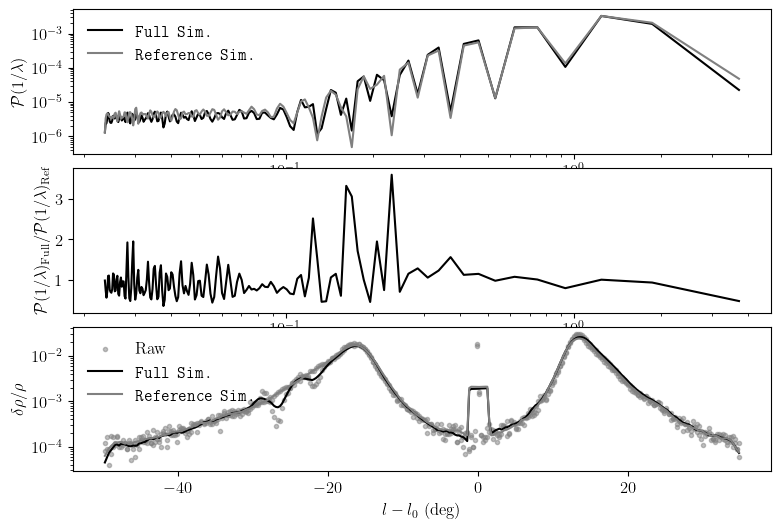

In [13]:
fig=plt.figure(figsize=(9, 6))
gs=fig.add_gridspec(3,1,hspace=0.1)
axis=[]
axis.append(fig.add_subplot(gs[0,0]))
axis.append(fig.add_subplot(gs[1,0]))
axis.append(fig.add_subplot(gs[2,0]))


axis[0].plot(1/frequencies[1::], np.abs(power_spectrum[1::]), label=r"\texttt{Full Sim.}",color='k')
axis[0].plot(1/frequenciesV[1::], np.abs(power_spectrumV[1::]), label=r"\texttt{Reference Sim.}",color='gray')
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel(r'$1/\lambda$ (deg)')
axis[0].set_ylabel(r'$\mathcal{P}(1/\lambda)$')
axis[0].legend(frameon=False)

axis[1].plot(1/frequency[1::], np.abs(power_spectrum[1::])/np.abs(power_spectrumV[1::]),color='k')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$1/\lambda$ (deg)')
axis[1].set_ylabel(r'$\mathcal{P}(1/\lambda)_{\mathrm{Full}}/\mathcal{P}(1/\lambda)_{\mathrm{Ref}}$')


axis[2].scatter(centers, normalized_counts,marker=".", color='gray',alpha=0.5)
axis[2].scatter(centers, normalized_countsV, marker=".",color='gray',alpha=0.5,label="Raw")
axis[2].plot(centers, smoothed_normalized_counts, color='k',label=r'\texttt{Full Sim.}')
axis[2].plot(centers, smoothed_normalized_countsV, color='gray',label=r'\texttt{Reference Sim.}')
axis[2].set_yscale('log')
axis[2].legend(frameon=False)


axis[2].set_xlabel(r'$l-l_0$ (deg)')
axis[2].set_ylabel(r'$\delta \rho/\rho$')


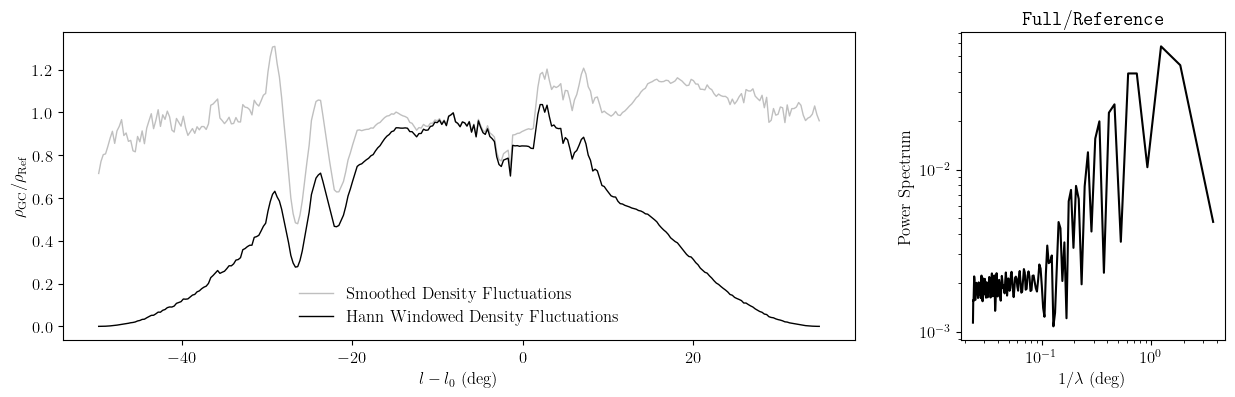

In [14]:
fig= plt.figure(figsize=(15,4))
gs=fig.add_gridspec(1,2,width_ratios=[3,1],wspace=0.2)
axis=[]
axis.append(fig.add_subplot(gs[0,0]))
axis.append(fig.add_subplot(gs[0,1]))
axis[0].plot(centers,density_fluctuations,color='gray',linewidth=1,alpha=0.5,label="Smoothed Density Fluctuations")
axis[0].plot(centers,windowed_fluctuations,color='k',linewidth=1,label="Hann Windowed Density Fluctuations")
axis[0].legend(frameon=False)
axis[0].set_xlabel(r'$l-l_0$ (deg)')
axis[0].set_ylabel(r'$\rho_{\mathrm{GC}}/\rho_{\mathrm{Ref}}$')


axis[1].plot(1/frequencies[1::], np.sqrt(power_spectrum[1::]), color='k')
axis[1].set_xlabel('1/$\lambda$ (deg)')
axis[1].set_ylabel('Power Spectrum')
axis[1].set_title(r'$\texttt{Full}/\texttt{Reference}$')
axis[1].set_xscale('log')
axis[1].set_yscale('log')

$$ [ w(n) = 0.5 \left(1 - \cos\left(\frac{2\pi n}{N-1}\right)\right) ] $$